# Handout #5: Unsupervised Learning (optimization-based clustering)

## Problem 7

### Definition of the crisp clustering function

In [22]:
import numpy as np
import random


def proximity_sense():
    # if the proximity function is a 
    # - dissimilarity metric (DM), must return the minimum function
    # - simillarity metric (SM), must return the maximum function
    
    # we are working with a distance, 
    # so a dissimilarity metric must be assumed => min
    
    return min


def get_best_cost_value(vector: np.ndarray) -> float:
    # returns the best cost value from 'cost_list'
    
    # will get the minimum or maximum value
    
    sense_func = proximity_sense()
    best_cost_value = sense_func(vector)
    
    return best_cost_value


def get_best_cost_index_from(vector: np.ndarray) -> int:
    # returns the position (zero indexed) of 
    # the minimum value or maximum value
    # that cotains 'values_list'
    
    best_position = vector.index(get_best_cost_value(vector))
    
    return best_position
    
    
def get_space_dimensions(X: np.ndarray) -> int:
    # returns the numbers of components of the datapoints
    # to classify
    
    if len(X.shape) == 2:
        n_dimensions = X.shape[1]
    else:
        raise TypeError("'X' must be a 2 dimension array")
    return n_dimensions


def get_initial_thetas(X: np.ndarray, M: int) -> np.ndarray:
    # returns a random matrix of cluster centroids
    #
    # the matrix shape is M-rows x L-cols
    # where M is the number of desired clusters
    # and L is the datapoints dimensionality
    
    n_dimensions = get_space_dimensions(X=X)
    
    # define a zeroed array (to be populated)
    thetas_array = np.zeros((M, n_dimensions), dtype=float)
    
    for j in range(n_dimensions):
        x_min = min(X[:, j])
        x_max = max(X[:, j])
        for i in range(M):
            thetas_array[i, j] = random.uniform(x_min, x_max)
    
    return thetas_array


def proximity_func():
    pass


def proximity_partial():
    pass


def calc_membership(func, X: np.ndarray, thetas: np.ndarray) -> np.ndarray:
    pass


def calc_thetas(func, X: np.ndarray, membership: np.ndarray) -> np.ndarray:
    
    return get_initial_thetas(X, 3)  # TODO


def calc_thetas_distance(new_thetas: np.ndarray, old_thetas: np.ndarray) -> float:
    # return the euclidean distance between thetas vectors
    #
    thetas_delta = (new_thetas - old_thetas)
    distance = np.linalg.norm(thetas_delta)
    
    return distance


def calc_cost_value(X: np.ndarray, membership: np.ndarray, thetas: np.ndarray) -> float:
    # return the cost function value
    #
    
    cost_value = np.random.random(1)
    
    return cost_value


def get_cluster_labels(thetas: np.ndarray) -> np.ndarray:
    pass


def do_crisp_clust(X: np.ndarray, M: int, n_iter: int , n_attempts: int, eps: float) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    
    # CONSTANTS
    #
    LABELS_FIELD = 'cluster_labels'
    THETAS_FIELD = 'theta_vector'
    COST_HIST_FIELD = 'cost_history'
    BEST_COST_FIELD = 'best_cost'
    
    # VARIABLES
    #
    
    # an empty list to store each attempt
    #
    attempt_list = list()
    
    # what is the cluster dimensionality
    #
    n_dimensions = get_space_dimensions(X=X)
    
    for attempt in range(n_attempts):
        
        # theta values initialization
        #
        thetas = get_initial_thetas(X=X, M=M)
        
        # cost function value history vector
        #
        cost_value_history = np.empty(0, dtype=float)
        
        # delta criteria finalization
        #
        delta = eps

        # iterations counter
        #
        it = 0

        # will iterate until n_iterations are exhausted or 
        # cost function value variation is above epsilon value
        #
        while it < n_iter and delta >= eps:
            
            # calc membership matrix
            #
            membership = calc_membership(
                func=proximity_func, 
                X=X, 
                thetas=thetas)
            
            # calculate next clusters centroids
            #
            old_thetas = thetas
            thetas = calc_thetas(
                func=proximity_partial, 
                X=X, 
                membership=membership)
            
            # calculate thetas delta
            #
            delta = calc_thetas_distance(
                new_thetas=thetas, 
                old_thetas=old_thetas)
            
            # calculate cost function value
            #
            cost_value = calc_cost_value(
                X=X, 
                membership=membership, 
                thetas=thetas)
            
            cost_value_history = np.append(
                cost_value_history, cost_value)
            
            # go to next try
            #
            it += 1
        
        # save results
        #
        best_cost_value = get_best_cost_value(
            vector=cost_value_history)
        
        cluster_labels = get_cluster_labels(thetas=thetas)
        
        new_entry = {
            LABELS_FIELD: cluster_labels,
            THETAS_FIELD: thetas,
            COST_HIST_FIELD: cost_value_history,
            BEST_COST_FIELD: best_cost_value
        }
        
        attempt_list.append(new_entry)
        
    # Select the best attempt
    #
    best_cost_value = None
    for attempt_entry in attempt_list:
        if best_cost_value is None or get_best_cost_index_from([attempt_entry[BEST_COST_FIELD], best_cost_value]) == 0:
            
            best_cluster_labels = attempt_entry[LABELS_FIELD]
            best_theta_vector = attempt_entry[THETAS_FIELD]
            best_cost_value_history = attempt_entry[COST_HIST_FIELD]
            best_cost_value = attempt_entry[BEST_COST_FIELD]
            
    return best_cluster_labels, best_theta_vector, best_cost_value_history

Load needed libraries

In [2]:
import numpy as np

### Load the *dataset*

Our group is '01'

In [3]:
group = '01'  # BERNAT LADARIA, Lluís
ds = 7

Load vectors from file

In [4]:
data = np.loadtxt('ds'+group+str(ds)+'.txt')

Split data and labels

In [5]:
X = data[:, 0:2]
y = data[:, 2]

How many vectors we have to classify?

In [6]:
X.shape

(300, 2)

How many classes?

In [7]:
y_classes = np.unique(y)
y_classes

array([0., 1., 2.])

We have a 3 classes classification problem

### Cluster the data

Import necessary functions and classes

In [8]:
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [9]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as col

Initialization

In [10]:
M = 3
n_iter = 20
n_attempts = 5
eps = 1e-3

Cluster it!

In [23]:
random.seed(42)

[best_cluster_labels, best_theta_vector, cost_value_history] = \
    do_crisp_clust(X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps)

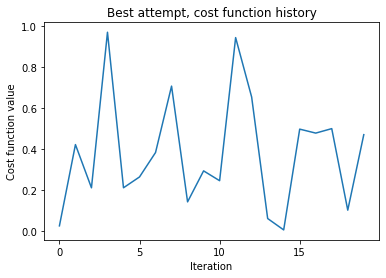

In [24]:
plt.title("Best attempt, cost function history")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
xticks_list = range(0, n_iter, 5)
plt.xticks(xticks_list)
plt.plot(cost_value_history)